In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data

sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

# look at all dsets

In [25]:
features = data.get_features() # uses several forms
outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
df = pd.merge(features, outcomes, on='id', how='left')

100%|██████████| 49/49 [00:01<00:00, 36.78it/s]
31it [00:01, 16.64it/s]

final shape (12044, 243)


### eda plots

In [5]:
missing_arr = np.zeros((len(fnames), NUM_PATIENTS + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
    df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1

In [ ]:
plt.figure(figsize=(5, 10))
sns.barplot(x=missing_arr.sum(axis=1), y=fnames, orient='h')
plt.xlabel('number of patients')
plt.savefig(oj(rdir, 'num_patients.png'))
plt.show()

In [ ]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=feature_names)
# plt.tight_layout()
# plt.savefig(oj(rdir, 'missing.png'))
plt.show()

In [ ]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

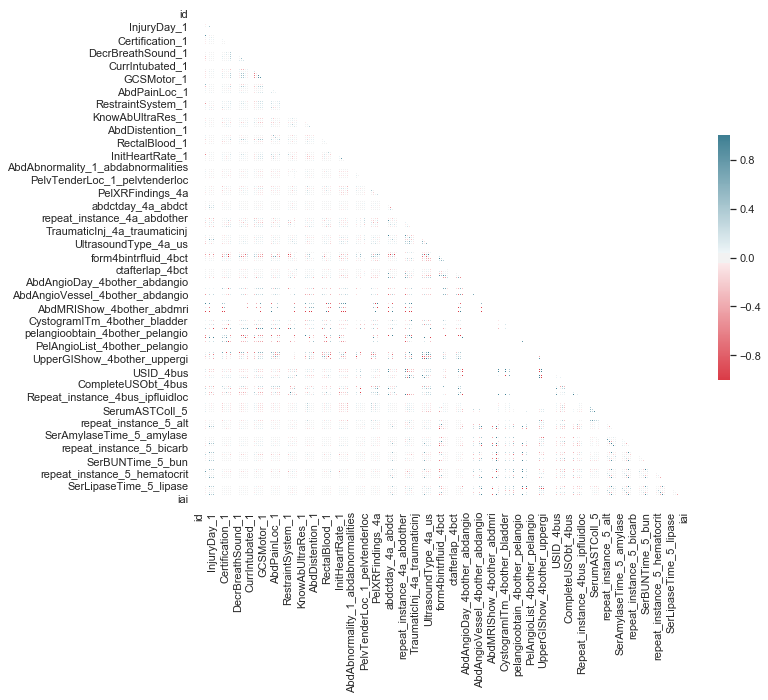

In [26]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr) #, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# look at demographics

In [19]:
# demographics = pd.read_csv('iaip_data/Datasets/demographics.csv').rename(columns={'SubjectID': 'id'})
# ids_np = np.array(list(ids)) - 1
ids_np = df.iai_intervention == 1
# vals = demographics.values[ids_np]
# print(list(demographics))
print(df.keys()[:10])

Index(['id', 'SEX', 'RACE', 'OTHER_RACE', 'HISPANIC_ETHNICITY', 'ageinyrs',
       'EDTriageDay_1', 'EDTriageTime_1', 'InjuryDay_1', 'InjuryTime_1'],
      dtype='object')


In [21]:
# the mean age is the only one which is wrong
print('age', np.mean(df.ageinyrs[ids_np]), np.mean(df.ageinyrs))
print('age<2', np.sum(df.ageinyrs[ids_np] < 2), np.sum(df.ageinyrs < 2))
print('sex', np.sum(df.SEX[ids_np] == 'M'), np.sum(df.SEX == 'M'))
print('hispanic ethnicity', np.sum(df.HISPANIC_ETHNICITY[ids_np] == 0), np.sum(df.HISPANIC_ETHNICITY == 0))

age 9.339901477832512 9.767270009963468
age<2 10 1167
sex 125 7384
hispanic ethnicity 119 7656


# correlations with outcome

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize)

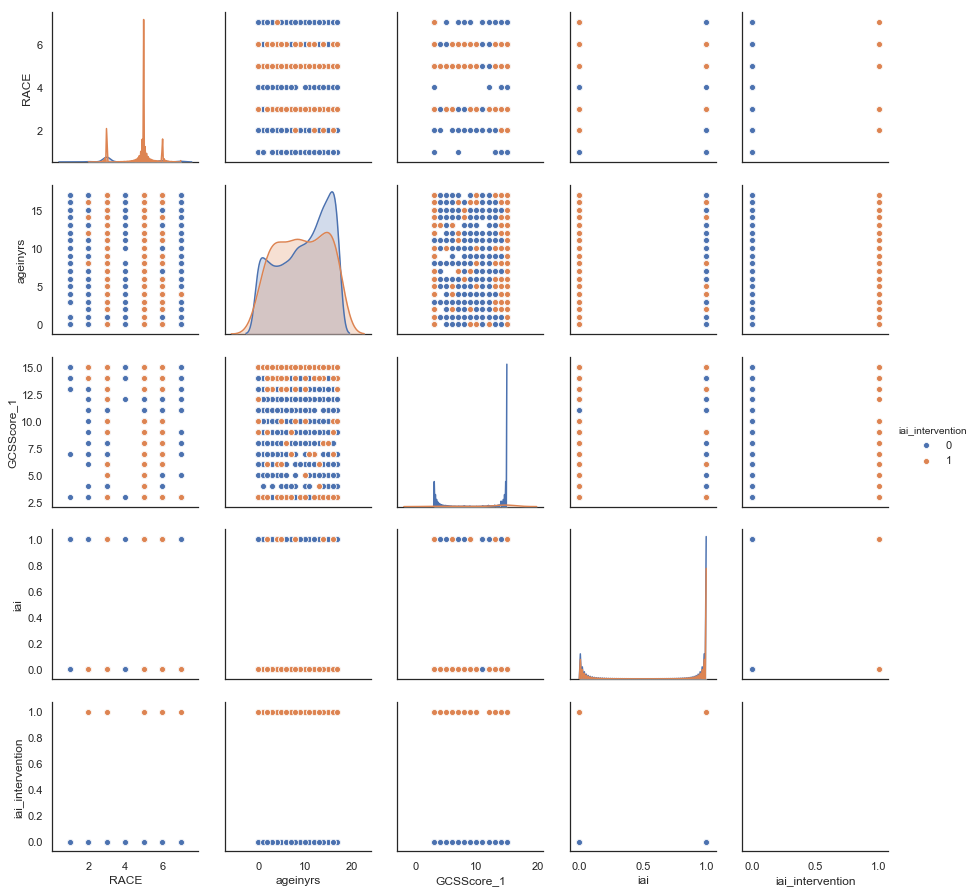

In [32]:
X = df[['SEX', 'RACE', 'ageinyrs', 'GCSScore_1', 'iai', 'iai_intervention']]

sns.pairplot(X, hue='iai_intervention')
plt.show()